<a href="https://colab.research.google.com/github/Farodoye-David/Cultural-Heritage/blob/main/Artifact_Detection_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
\from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
print(os.listdir('/content/drive/MyDrive/Datasets (1)'))

['Ceremonial Regalia & Objects', 'Altar & Shrine Objects', 'Palace Architecture & Ornamentation']


In [ ]:
# Ignore  the warnings
import warnings
warnings.filterwarnings('always')
warnings.filterwarnings('ignore')

# data visualisation and manipulation
import numpy as np
import pandas as pd
import imghdr
import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns

#configure
# sets matplotlib to inline and displays graphs below the corressponding cell.
%matplotlib inline
style.use('fivethirtyeight')
sns.set(style='whitegrid',color_codes=True)

#model selection
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score,precision_score,recall_score,confusion_matrix,roc_curve,roc_auc_score, f1_score, classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import LabelEncoder

#preprocess.
from keras.preprocessing.image import ImageDataGenerator

#dl libraraies
from keras import backend as K
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam,SGD,Adagrad,Adadelta,RMSprop
from keras.utils import to_categorical
from keras.callbacks import ReduceLROnPlateau

# specifically for cnn
from keras.layers import Dropout, Flatten,Activation
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization

import tensorflow as tf
import random as rn

# specifically for manipulating zipped images and getting numpy arrays of pixel values of images.
import cv2
import numpy as np
from tqdm import tqdm
import os
from random import shuffle
from zipfile import ZipFile
from PIL import Image

In [ ]:
X=[]
Z=[]
IMG_SIZE=224
ALTAR_SHRINE_OBJECTS_DIR='/content/drive/MyDrive/Datasets (1)/Altar & Shrine Objects'
CEREMONIAL_REGALIA_OBJECTS_DIR='/content/drive/MyDrive/Datasets (1)/Ceremonial Regalia & Objects'
PALACE_ARCHITECTURE_DIR='/content/drive/MyDrive/Datasets (1)/Palace Architecture & Ornamentation'

In [ ]:
def assign_label(img,artifact_type):
    return artifact_type

In [ ]:
img_type_acc = ['bmp', 'gif', 'jpeg', 'png', 'webp']

def make_train_data(artifact_type,DIR):
    for img in tqdm(os.listdir(DIR)):
        label=assign_label(img,artifact_type)
        path = os.path.join(DIR,img)
        img_type = imghdr.what(path)

        img = cv2.imread(path, cv2.IMREAD_COLOR)
        if img is None:
          print("Error: Image not loaded correctly.")
        elif img.size == 0:
          print("Error: Loaded image is empty.")
        else:
          img = cv2.resize(img, (IMG_SIZE,IMG_SIZE))

          X.append(np.array(img))
          Z.append(str(label))

In [ ]:
make_train_data('Altar and Shrine Objects',ALTAR_SHRINE_OBJECTS_DIR)
print(len(X))

 22%|██▏       | 191/852 [00:27<00:06, 105.91it/s]

Error: Image not loaded correctly.


100%|██████████| 852/852 [00:33<00:00, 25.10it/s]

851


In [ ]:
make_train_data('Ceremonial Regalia and Objects',CEREMONIAL_REGALIA_OBJECTS_DIR)
print(len(X))

100%|██████████| 608/608 [00:19<00:00, 31.53it/s] 

1459


In [ ]:
make_train_data('Palace Architecture and Ornamentation',PALACE_ARCHITECTURE_DIR)
print(len(X))

100%|██████████| 705/705 [00:24<00:00, 28.77it/s]

2164


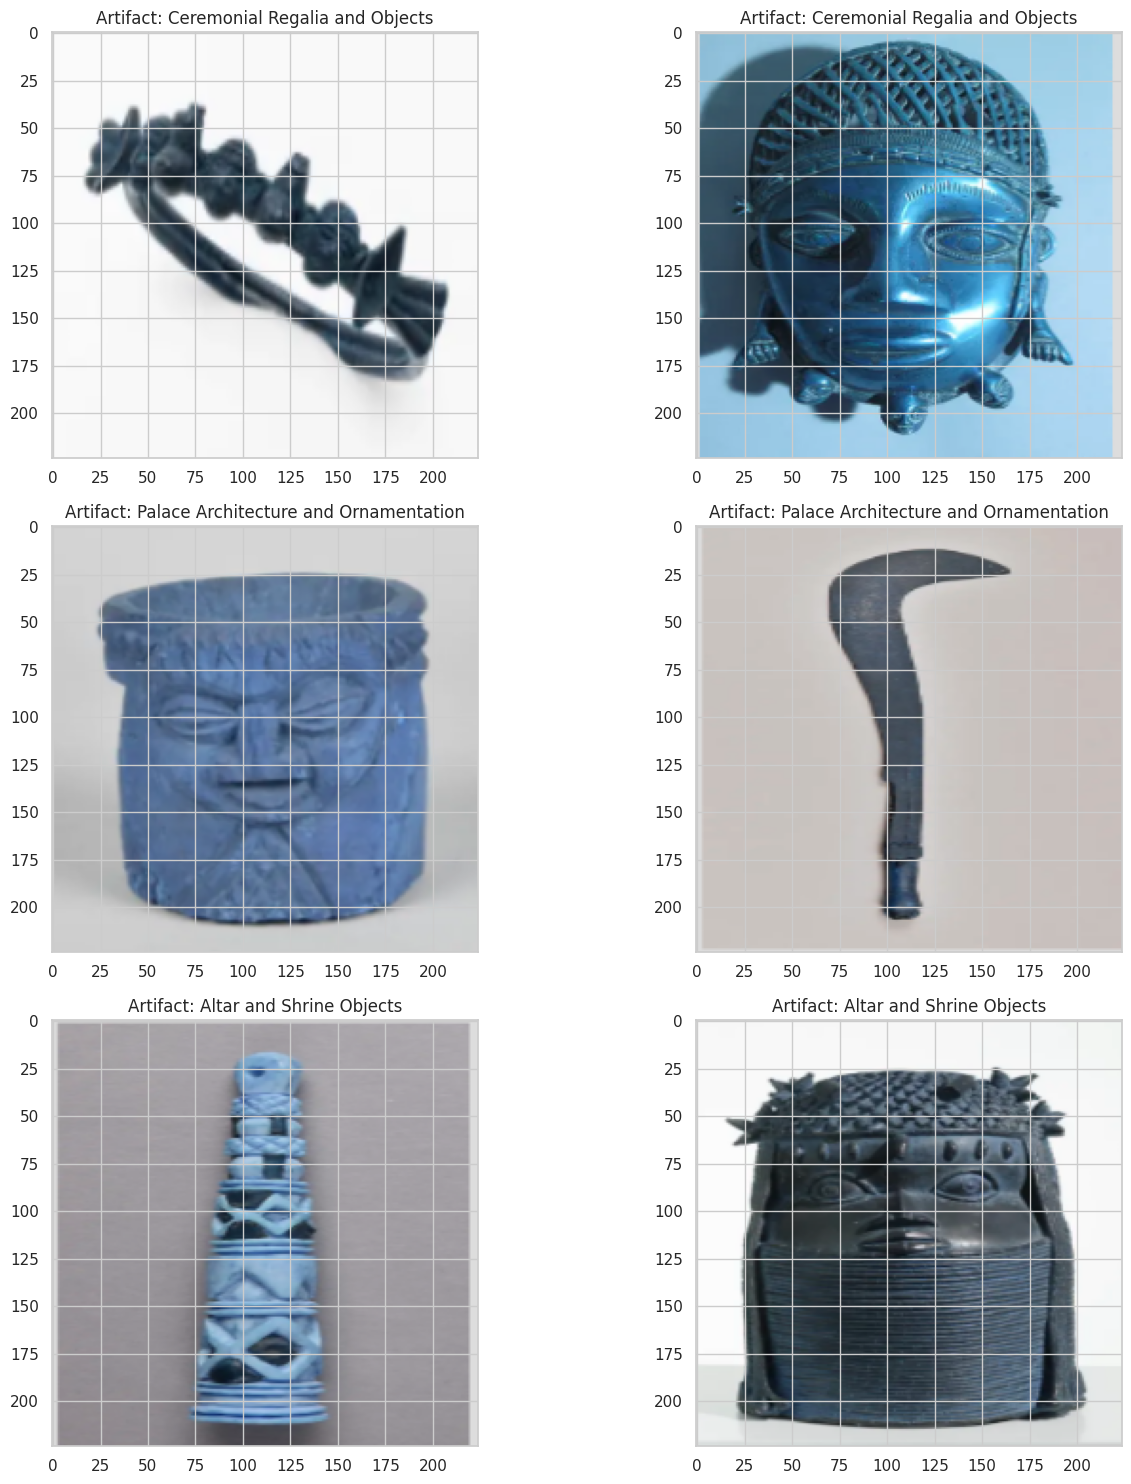

In [ ]:
fig,ax=plt.subplots(3,2)
fig.set_size_inches(15,15)
for i in range(3):
    for j in range (2):
        l=rn.randint(0,len(Z))
        ax[i,j].imshow(X[l])
        ax[i,j].set_title('Artifact: '+Z[l])

plt.tight_layout()

In [ ]:
# Check the unique classes and the number of classes
unique_classes = len(np.unique(Z))
print(f'Number of unique classes: {unique_classes}')

# Encode labels and convert to categorical
le = LabelEncoder()
Y = le.fit_transform(Z)
Y = to_categorical(Y, num_classes=3)
X=np.array(X)
X=X/255

Number of unique classes: 3


In [ ]:
# Split the data into training and testing sets
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.25, random_state=42)


In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D

input_shape = (224, 224, 3)

# Initialize the DenseNet201 model without the top layer
base_model = tf.keras.applications.DenseNet201(weights='imagenet', include_top=False, input_shape=input_shape)

# Add global average pooling to reduce the dimensionality
x = base_model.output
x = GlobalAveragePooling2D()(x)

# Add a fully connected layer
x = Dense(128, activation='relu')(x)

# Add the output layer with the number of units equal to the number of classes
predictions = Dense(3, activation='softmax')(x)  # Adjusted for 3 classes

# Define the final model
model = Model(inputs=base_model.input, outputs=predictions)

# Freeze the layers of the base model
for layer in base_model.layers:
    layer.trainable = False

# Compile the model
model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

# Summary of the model
model.summary()

# Create an ImageDataGenerator instance for data augmentation
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Fit the ImageDataGenerator to the training data
datagen.fit(x_train)

# Define a learning rate reduction callback
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.001)

# Train the model
History = model.fit(datagen.flow(x_train, y_train, batch_size=32), epochs=10, validation_data=(x_test, y_test), callbacks=[reduce_lr])

# Unfreeze some of the layers and fine-tune
for layer in base_model.layers[-50:]:
    layer.trainable = True

# Compile the model again with a lower learning rate for fine-tuning
model.compile(optimizer=Adam(learning_rate=1e-5), loss='categorical_crossentropy', metrics=['accuracy'])

# Fine-tune the model
History_fine_tune = model.fit(datagen.flow(x_train, y_train, batch_size=32), epochs=10, validation_data=(x_test, y_test), callbacks=[reduce_lr])

74836368/74836368 [==============================] - 4s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 zero_padding2d (ZeroPaddin  (None, 230, 230, 3)          0         ['input_1[0][0]']             
 g2D)                                                                                             
                                                                                                  
 conv1/conv (Conv2D)         (None, 112, 112, 64)         9408      ['zero_padding2d[0][0]']      
                                                                                                  
 conv1/bn (BatchNormalizati  

In [ ]:
#basemodel = tf.keras.applications.DenseNet201(weights = "imagenet", include_top = False, input_shape = (224, 224, 3) )

In [ ]:
#basemodel.trainable = False

In [ ]:
#for layer in basemodel.layers[:-5]:
#  layer.trainable=False

In [ ]:
# Define the model
'''model = Sequential()
#model.add(Conv2D(filters=32, kernel_size=(5, 5), padding='Same', activation='relu', input_shape=(256, 256, 3)))
#model.add(MaxPooling2D(pool_size=(2, 2)))
#model.add(Conv2D(filters=64, kernel_size=(3, 3), padding='Same', activation='relu'))
#model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
#model.add(Conv2D(filters=96, kernel_size=(3, 3), padding='Same', activation='relu'))
#model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
model.add(basemodel)
model.add(Conv2D(filters=64, kernel_size=(3, 3), padding='Same', activation='relu'))
#model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
#model.add(Flatten())
model.add(tf.keras.layers.GlobalAveragePooling2D())
model.add(Dense(256, activation='relu'))
model.add(Dense(3, activation='softmax'))'''

"model = Sequential()\n#model.add(Conv2D(filters=32, kernel_size=(5, 5), padding='Same', activation='relu', input_shape=(256, 256, 3)))\n#model.add(MaxPooling2D(pool_size=(2, 2)))\n#model.add(Conv2D(filters=64, kernel_size=(3, 3), padding='Same', activation='relu'))\n#model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))\n#model.add(Conv2D(filters=96, kernel_size=(3, 3), padding='Same', activation='relu'))\n#model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))\nmodel.add(basemodel)\nmodel.add(Conv2D(filters=64, kernel_size=(3, 3), padding='Same', activation='relu'))\n#model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))\n#model.add(Flatten())\nmodel.add(tf.keras.layers.GlobalAveragePooling2D())\nmodel.add(Dense(256, activation='relu'))\nmodel.add(Dense(3, activation='softmax'))"

In [ ]:
'''# Using LR Annealer
batch_size = 32
epochs = 10

#red_lr = ReduceLROnPlateau(monitor='val_accuracy', patience=3, verbose=1, factor=0.1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.001)'''

"# Using LR Annealer\nbatch_size = 32\nepochs = 10\n\n#red_lr = ReduceLROnPlateau(monitor='val_accuracy', patience=3, verbose=1, factor=0.1)\nreduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.001)"

In [ ]:
# Data Augmentation to prevent overfitting
'''datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'

    #rotation_range=10,
    #zoom_range=0.1,
    #width_shift_range=0.2,
    #height_shift_range=0.2,
    #horizontal_flip=True,
)

datagen.fit(x_train)'''

"datagen = ImageDataGenerator(\n    rotation_range=20,\n    width_shift_range=0.2,\n    height_shift_range=0.2,\n    shear_range=0.2,\n    zoom_range=0.2,\n    horizontal_flip=True,\n    fill_mode='nearest'\n\n    #rotation_range=10,\n    #zoom_range=0.1,\n    #width_shift_range=0.2,\n    #height_shift_range=0.2,\n    #horizontal_flip=True,\n)\n\ndatagen.fit(x_train)"

In [ ]:
'''model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()'''

"model.compile(\n    optimizer=Adam(learning_rate=0.0001),\n    loss='categorical_crossentropy',\n    metrics=['accuracy']\n)\n\nmodel.summary()"

In [ ]:
'''# Train the model
History = model.fit(
    datagen.flow(x_train, y_train, batch_size=batch_size),
    epochs=epochs,
    validation_data=(x_test, y_test),
    verbose=1,
    steps_per_epoch=x_train.shape[0] // batch_size,
    callbacks=[reduce_lr]
)'''

'# Train the model\nHistory = model.fit(\n    datagen.flow(x_train, y_train, batch_size=batch_size),\n    epochs=epochs,\n    validation_data=(x_test, y_test),\n    verbose=1,\n    steps_per_epoch=x_train.shape[0] // batch_size,\n    callbacks=[reduce_lr]\n)'

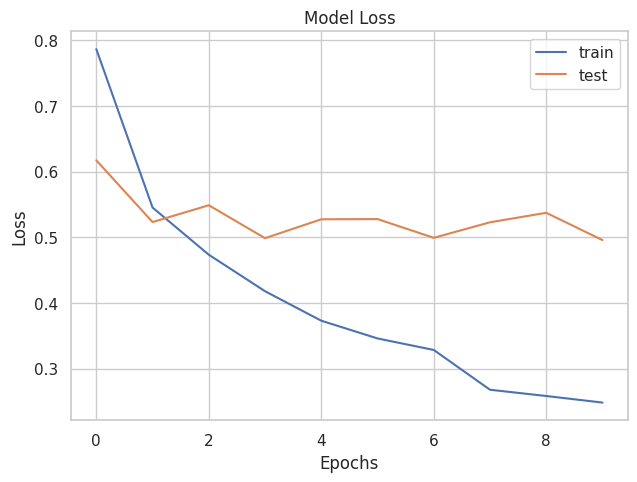

In [ ]:
## Evaluating the model's performance
plt.plot(History.history['loss'])
plt.plot(History.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'test'])
plt.show()

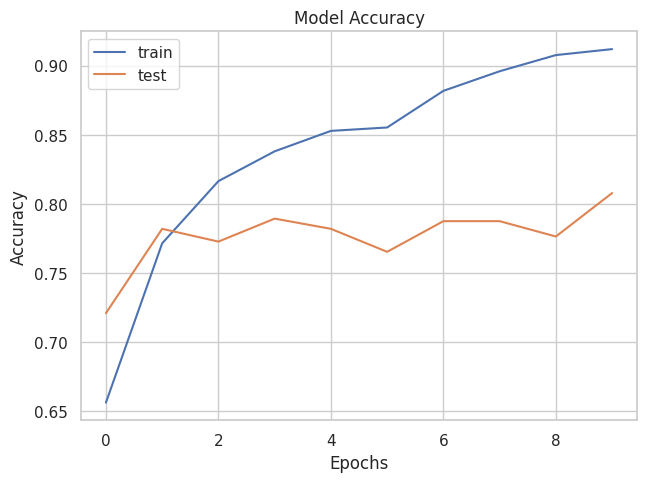

In [ ]:
plt.plot(History.history['accuracy'])
plt.plot(History.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'test'])
plt.show()

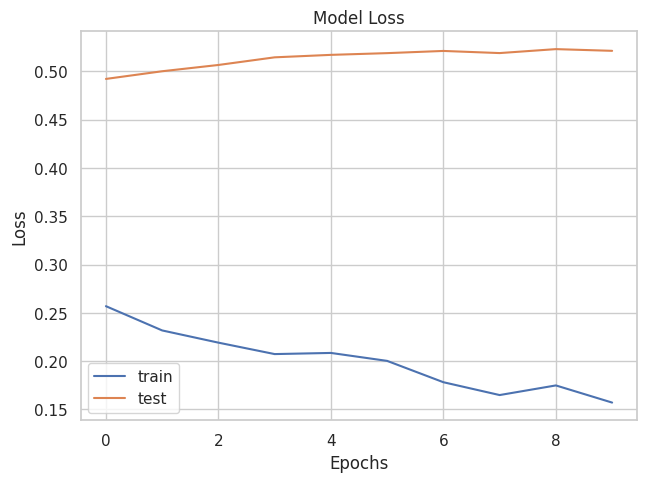

In [ ]:
## Evaluating the model's performance
plt.plot(History_fine_tune.history['loss'])
plt.plot(History_fine_tune.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'test'])
plt.show()

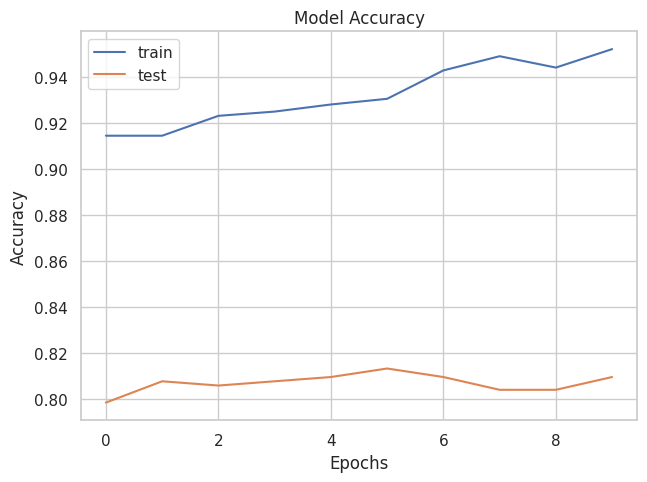

In [ ]:
plt.plot(History_fine_tune.history['accuracy'])
plt.plot(History_fine_tune.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'test'])
plt.show()

In [ ]:
## Visualizing Predictons on the Validation Set
# getting predictions on val set.
pred=model.predict(x_test)
pred_digits=np.argmax(pred,axis=1)

17/17 [==============================] - 6s 149ms/step


In [ ]:
# now storing some properly as well as misclassified indexes'.
i=0
prop_class=[]
mis_class=[]

for i in range(len(y_test)):
    if(np.argmax(y_test[i])==pred_digits[i]):
        prop_class.append(i)
    if(len(prop_class)==8):
        break

i=0
for i in range(len(y_test)):
    if(not np.argmax(y_test[i])==pred_digits[i]):
        mis_class.append(i)
    if(len(mis_class)==8):
        break

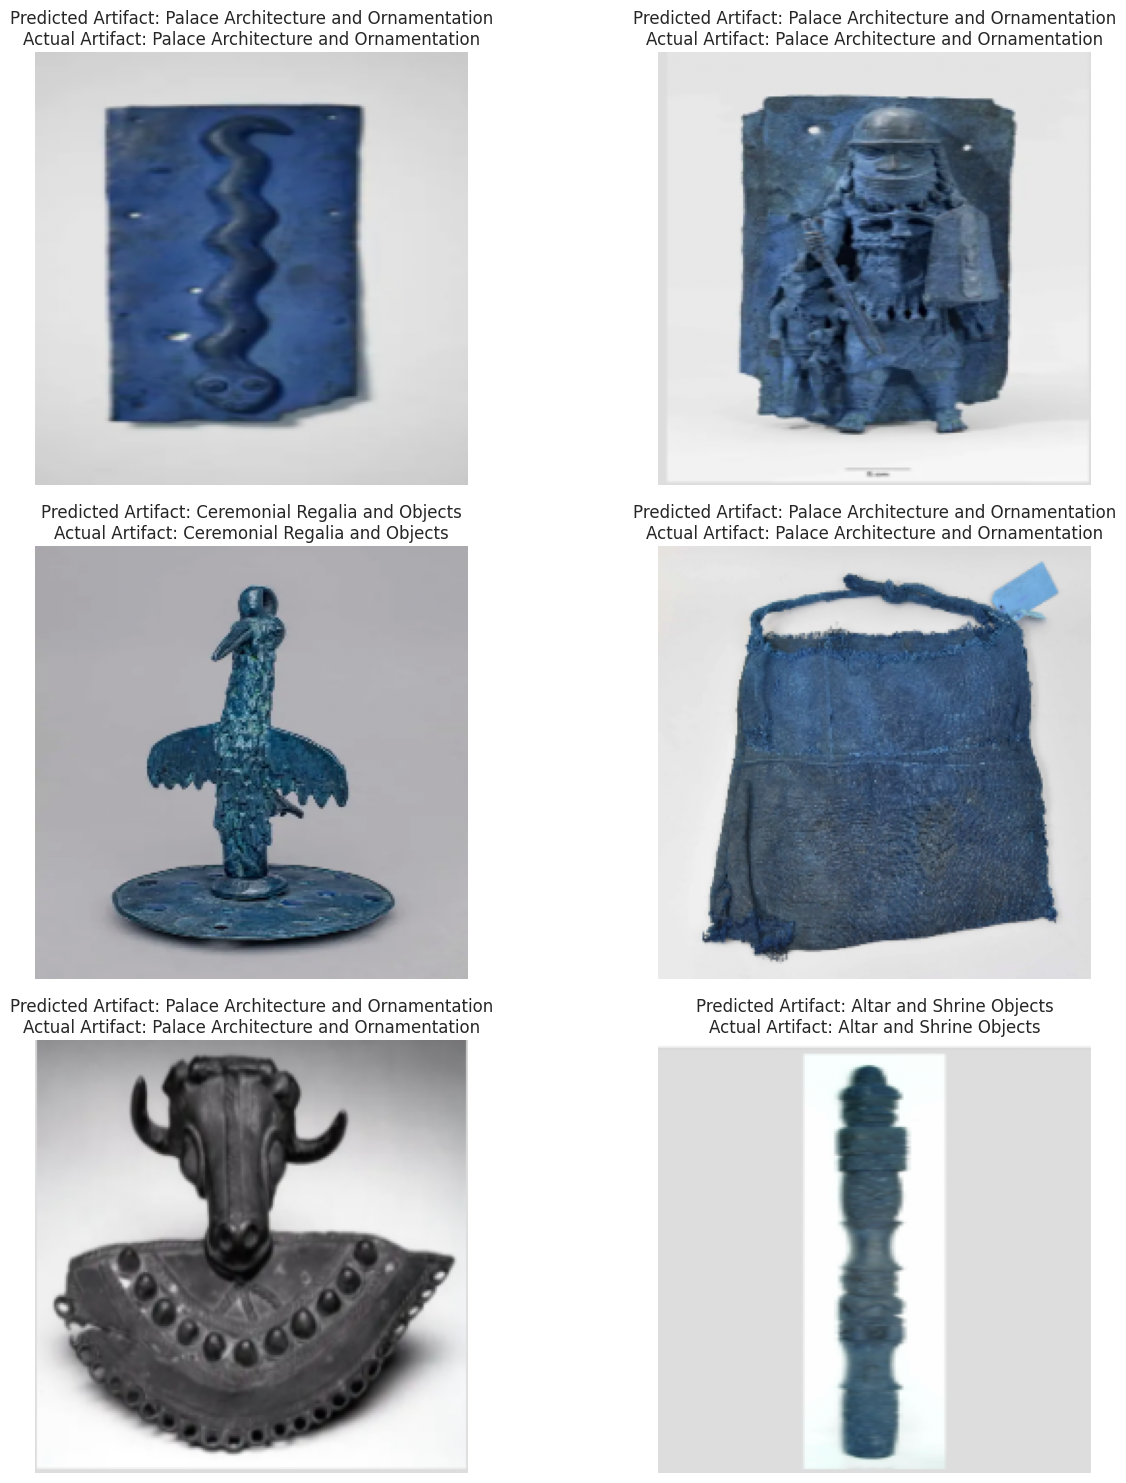

'count=0\nfig,ax=plt.subplots(4,2)\nfig.set_size_inches(15,15)\nfor i in range (4):\n    for j in range (2):\n        ax[i,j].imshow(x_test[prop_class[count]])\n        ax[i,j].set_title("Predicted Artifact : "+str(le.inverse_transform([pred_digits[prop_class[count]]]))+"\n"+"Actual Artifact : "+str(le.inverse_transform(np.argmax([y_test[prop_class[count]]]))))\n        plt.tight_layout()\n        count+=1'

In [ ]:
## CORRECTLY CLASSIFIED FLOWER IMAGES
warnings.filterwarnings('always')
warnings.filterwarnings('ignore')

count = 0
fig, ax = plt.subplots(3, 2)
fig.set_size_inches(15, 15)
for i in range(3):
    for j in range(2):
        if count < len(prop_class):
            ax[i, j].imshow(x_test[prop_class[count]])
            predicted_label = le.inverse_transform([pred_digits[prop_class[count]]])[0]
            actual_label = le.inverse_transform([np.argmax(y_test[prop_class[count]])])[0]
            ax[i, j].set_title(f"Predicted Artifact: {predicted_label}\nActual Artifact: {actual_label}")
            ax[i, j].axis('off')
            count += 1
        else:
            ax[i, j].axis('off')
plt.tight_layout()
plt.show()

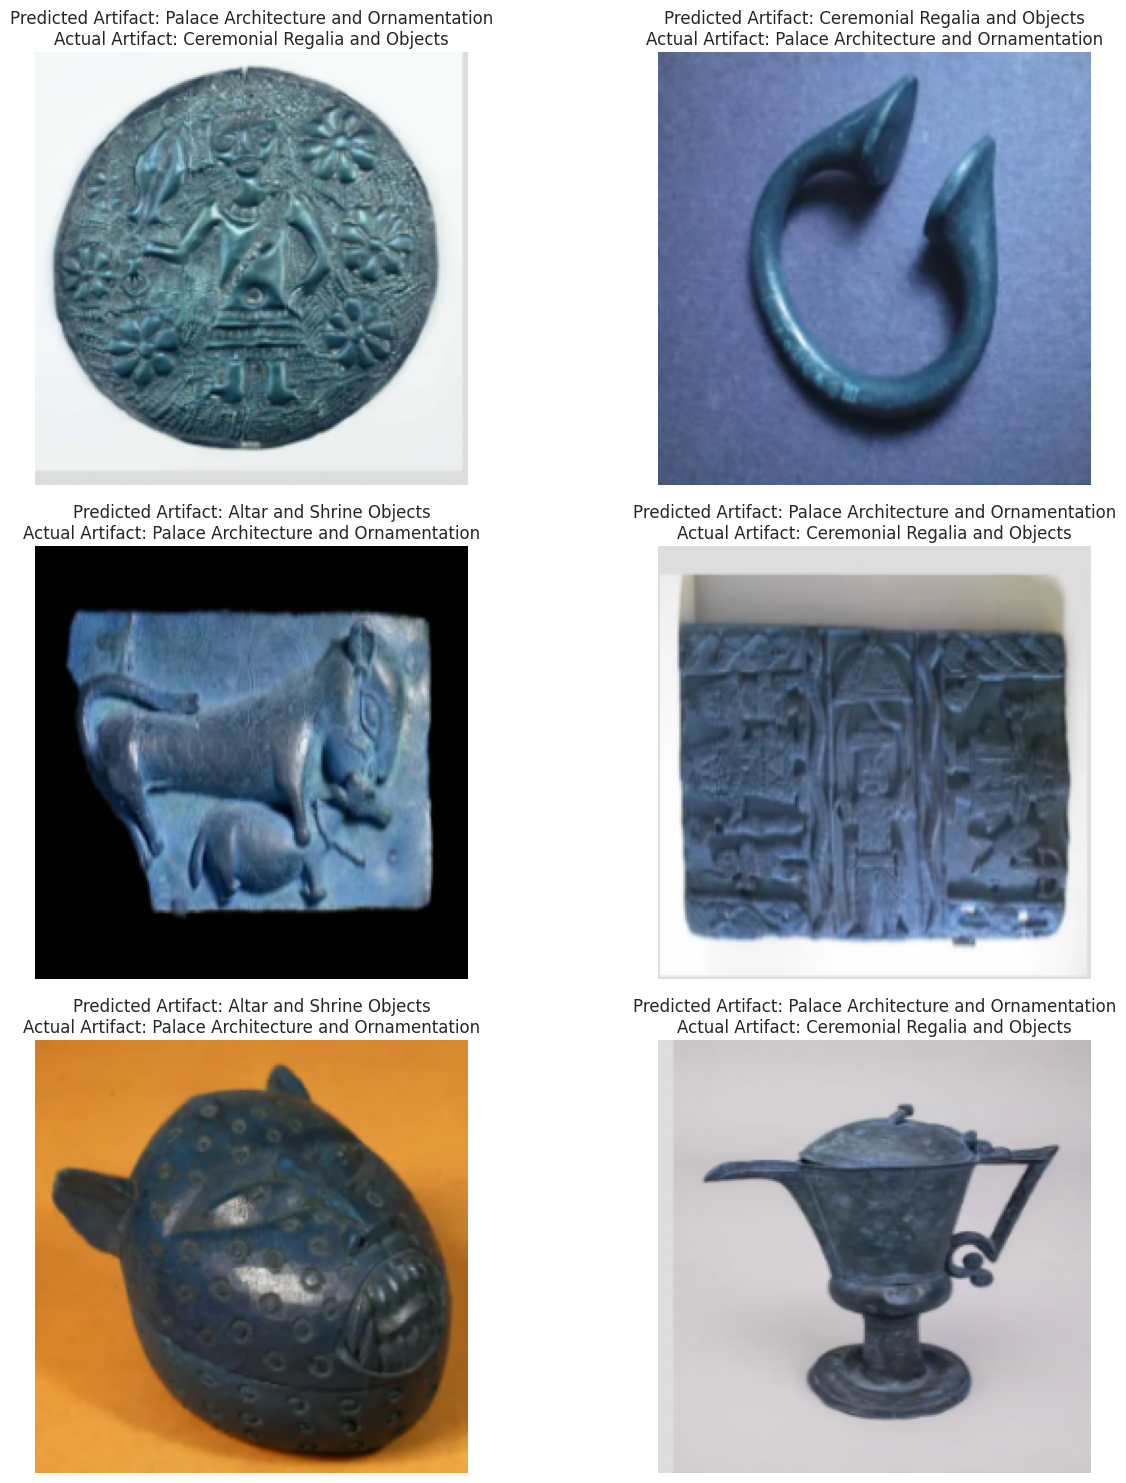

'count=0\nfig,ax=plt.subplots(4,2)\nfig.set_size_inches(15,15)\nfor i in range (4):\n    for j in range (2):\n        ax[i,j].imshow(x_test[mis_class[count]])\n        ax[i,j].set_title("Predicted Artifact : "+str(le.inverse_transform([pred_digits[mis_class[count]]]))+"\n"+"Actual Artifact : "+str(le.inverse_transform(np.argmax([y_test[mis_class[count]]]))))\n        plt.tight_layout()\n        count+=1'

In [ ]:
## MISCLASSIFIED IMAGES OF FLOWERS
warnings.filterwarnings('always')
warnings.filterwarnings('ignore')

count = 0
fig, ax = plt.subplots(3, 2)
fig.set_size_inches(15, 15)
for i in range(3):
    for j in range(2):
        if count < len(mis_class):
            ax[i, j].imshow(x_test[mis_class[count]])
            predicted_label = le.inverse_transform([pred_digits[mis_class[count]]])[0]
            actual_label = le.inverse_transform([np.argmax(y_test[mis_class[count]])])[0]
            ax[i, j].set_title(f"Predicted Artifact: {predicted_label}\nActual Artifact: {actual_label}")
            ax[i, j].axis('off')
            count += 1
        else:
            ax[i, j].axis('off')
plt.tight_layout()
plt.show()

In [ ]:
# Convert one-hot encoded y_test to label indices if needed
y_test_labels = np.argmax(y_test, axis=1)

# Get predictions from the model
y_pred = model.predict(x_test)
y_pred_labels = np.argmax(y_pred, axis=1)

17/17 [==============================] - 2s 148ms/step


In [ ]:
# Accuracy
accuracy = accuracy_score(y_test_labels, y_pred_labels)
print(f'Accuracy: {accuracy:.4f}')

# Precision
precision = precision_score(y_test_labels, y_pred_labels, average='weighted')
print(f'Precision: {precision:.4f}')

# Recall
recall = recall_score(y_test_labels, y_pred_labels, average='weighted')
print(f'Recall: {recall:.4f}')

# F1-Score
f1 = f1_score(y_test_labels, y_pred_labels, average='weighted')
print(f'F1-Score: {f1:.4f}')

# Confusion Matrix
conf_matrix = confusion_matrix(y_test_labels, y_pred_labels)
print('Confusion Matrix:')
print(conf_matrix)

# Classification Report
class_report = classification_report(y_test_labels, y_pred_labels, target_names=le.classes_)
print('Classification Report:')
print(class_report)

Accuracy: 0.8096
Precision: 0.8123
Recall: 0.8096
F1-Score: 0.8101
Confusion Matrix:
[[177  14  23]
 [ 12 111  24]
 [ 13  17 150]]
Classification Report:
                                       precision    recall  f1-score   support

             Altar and Shrine Objects       0.88      0.83      0.85       214
       Ceremonial Regalia and Objects       0.78      0.76      0.77       147
Palace Architecture and Ornamentation       0.76      0.83      0.80       180

                             accuracy                           0.81       541
                            macro avg       0.81      0.81      0.80       541
                         weighted avg       0.81      0.81      0.81       541

